# Create a map of the Ambulance Service regions

See https://www.overleaf.com/project/63e3af828a2b446a5a6a447a and 11_clip_lsoas_to_county.ipynb

In England and Wales there are 11 Ambulance Services.

An image of the Ambulance Service catchments can be found at https://aace.org.uk/uk-ambulance-service/map-of-nhs-ambulance-services/ (Association of Ambulance Cheif Executives).

We have been advised by Steve Irving (Executive Officer / ALF Conference Lead) that the map "is just an approximation of the boundaries, purely for illustrative / navigational purposes".

We aim to build a map of the Ambulance Service regions from the individual LSOAs up.

Here we link together two datafiles that take us from LSOA to CCG, and then from CCG to Ambulance Service:
1) LSOA to CCG (Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(April_2021)_Lookup_in_England.csv)
2) CCG to Ambulance Service ("ambulance_service_info.xlsx", sheet Ambulance CCG lookup. Extracted and created "ambulance_service_info_ccg_lookup.csv"). Do not use "NHS Ambulance Service Region Name" as this is not a name per Ambulance Service. Instead set up a dictionary and create a new field "Ambulance Service Name" from the code contained in the field "Ambulane Service".

There is a complications using this approach. Two CCGs are split across two Ambulance Services:
1) NHS Hampshire, Southampton and Isle of Wight CCG is partly covered by Isle of Wight Ambulance Service, partly by SCAS.
2) NHS Bedfordshire, Luton and Milton Keynes CCG is partly covered by EEAST, partly by SCAS.

We manage this by taking this approach:
1) All LSOA names containing "Isle of Wight" get assigned to Isle of Wight Ambulance Service, the rest of the LSOAs that make up the "NHS Hampshire, Southampton and Isle of Wight CCG" get assigned to SCAS.
2) NHS Bedfordshire, Luton and Milton Keynes CCG spans two counties: Bedfordshire and Buckinhamshire. The catchemnt maps on the respective Ambulance Service websites showed that the Ambulance Service EEAST serves the county of Bedfordhsire, and the Ambulance Service SCAS serves the county of Buckinghamshire. Using a shapefile of the UK Counties, extract the individual polygons for i) Bedfordshire ii) Buckinghamshire and in turn use these to identify the LSOAs in each. For the LSOAs in the NHS Bedfordshire, Luton and Milton Keynes CCG, use their location in relation to these two counties to determine whether they are part of the EEAST or SCAS. 

Another complication is that Wales is not included in the LSOA to CCG datafile, and so would otherwise not be included in this analysis.

Note: Code cell "gdf_beds_lsoa = gpd.clip(gdf_beds_county, gdf_lsoa)" takes a few hours to run. So read in the created shapefile (same for the Bucks equivalent)

https://aace.org.uk/uk-ambulance-service/map-of-nhs-ambulance-services/
https://commons.wikimedia.org/wiki/File:Ambulance-Services-in-England-map.png

https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.nicepng.com%2Fpng%2Fdetail%2F990-9907422_regions-uk-ambulance-services-map.png&imgrefurl=https%3A%2F%2Fwww.nicepng.com%2Fourpic%2Fu2y3w7r5a9u2q8e6_regions-uk-ambulance-services-map%2F&tbnid=cGvrIvNc6xaCAM&vet=12ahUKEwiV7IDt4fn8AhUARKQEHR_dB-AQMyg3egQIARBO..i&docid=gdLooZ3wfoyLDM&w=820&h=697&q=south%20east%20coast%20ambulance%20service%20map&client=ubuntu&ved=2ahUKEwiV7IDt4fn8AhUARKQEHR_dB-AQMyg3egQIARBO

https://www.researchgate.net/publication/257019478_Cycle_response_unit_paramedics

https://www.semanticscholar.org/paper/Data-for-Ambulance-Dispatch%3A-New-%26-emerging-forms-Drake-Pollitt/382dd6b762ae64f30c22d0e3046e1aa055b5f7f5

https://www.bbc.co.uk/news/health-16052725

East Midlands Ambulance Service (EMAS)
https://commons.wikimedia.org/wiki/File:East-Midlands-Ambulance-Service-map.png

East of England Ambulance Service Trust (EEAST)
https://www.eastamb.nhs.uk/join-the-team/our-stations.htm

London Ambulance Service (LAS)

North East Ambulance Service (NEAS)
https://north-east-ambulance-service.v3.gsmicrosites.net/about-us
https://www.neas.nhs.uk/about-us/who-we-are-and-what-we-do.aspx
"The North East Ambulance Service NHS Foundation Trust (NEAS) operates across Northumberland, Tyne and Wear, County Durham, Darlington and Teesside"


North West Ambulance Service (NWAS)


South Central Ambulance Service (SCAS)
https://www.scas.nhs.uk/about-scas/

South East Coast Ambulance Service (SECAmb)
https://www.secamb.nhs.uk/what-we-do/about-us/
"Covers a geographical area of 3,600 square miles (Brighton & Hove, East Sussex, West Sussex, Kent, Surrey, and North East Hampshire)"

West Midlands Ambulance Service (WMAS)
https://wmas.nhs.uk/


South West Ambulance Service (SWAS)

Yorkshire Ambulance Service (YAS)
Welsh Ambulance Service (WAS)



In [ ]:
#Image(url="images/map 1 labels.png", width=300, height=300)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import os
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from IPython.display import Image

dict_amb_service_name = {'EMAS':'East Midlands Ambulance Service',
                         'EEAST':'East of England Ambulance Service Trust',
                         'LAS':'London Ambulance Service',
                         'NEAS':'North East Ambulance Service',
                         'NWAS':'North West Ambulance Service',
                         'SCAS':'South Central Ambulance Service',
                         'SECAmb':'South East Coast Ambulance Service',
                         'WMAS':'West Midlands Ambulance Service',
                         'SWAS':'South West Ambulance Service',
                         'YAS':'Yorkshire Ambulance Service'}


In [3]:
dict_amb_service_name = {'EMAS':'East Midlands',
                         'EEAST':'East of England',
                         'LAS':'London',
                         'NEAS':'North East',
                         'NWAS':'North West',
                         'SCAS':'South Central',
                         'SECAmb':'South East Coast',
                         'WMAS':'West Midlands',
                         'SWAS':'South West',
                         'YAS':'Yorkshire'}

Read in LSOA to CCG

In [4]:
lsoa_ccg_data = pd.read_csv('./data/demographic/Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(April_2021)_Lookup_in_England.csv', 
                   index_col='CCG21NM')
lsoa_ccg_data.head(2)

FID   LSOA11CD       LSOA11NM    CCG21CD CCG21CDH  \
CCG21NM                                                               
NHS Barnsley CCG    1  E01007420  Barnsley 016C  E38000006      02P   
NHS Barnsley CCG    2  E01007317  Barnsley 018A  E38000006      02P   

                    LAD21CD   LAD21NM  
CCG21NM                                
NHS Barnsley CCG  E08000016  Barnsley  
NHS Barnsley CCG  E08000016  Barnsley

Read in CCG to Ambulance datafile, and edit the data to get it ready before joining with the LSOA to CCG dataset.

In [5]:
ccg_ambo_data = pd.read_csv('./data/demographic/ambulance_service_info_ccg_lookup.csv')
ccg_ambo_data.head(2)

NHS CCG code                                 CCG name  \
0          02Q                        NHS Bassetlaw CCG   
1          03W  NHS East Leicestershire and Rutland CCG   

  Office for National Statistics (ONS) April 2021 CCG code Ambulance Service   \
0                                          E38000008                     EMAS   
1                                          E38000051                     EMAS   

  NHS Ambulance Service Region Name NHS Ambulance Service  Region code  \
0                          Midlands                                Y60   
1                          Midlands                                Y60   

  ONS Ambulance Service  Region Code  
0                          E40000008  
1                          E40000008

In [6]:
ccg_ambo_data.columns

Index(['NHS CCG code', 'CCG name',
       'Office for National Statistics (ONS) April 2021 CCG code',
       'Ambulance Service ', 'NHS Ambulance Service Region Name',
       'NHS Ambulance Service  Region code',
       'ONS Ambulance Service  Region Code'],
      dtype='object')

In [7]:
# find lsoa
mask = lsoa_ccg_data.LSOA11CD == "E01017652"
# get CCG for that lsoa and find that CCG in the ambulance data
mask1 = ccg_ambo_data["CCG name"] == lsoa_ccg_data[mask].index.values[0]
# Look at the ambulance service for that ccg (for that lsoa)
ccg_ambo_data[mask1]

NHS CCG code                 CCG name  \
66          14Y  NHS Buckinghamshire CCG   

   Office for National Statistics (ONS) April 2021 CCG code  \
66                                          E38000223         

   Ambulance Service  NHS Ambulance Service Region Name  \
66               SCAS                        South East   

   NHS Ambulance Service  Region code ONS Ambulance Service  Region Code  
66                                Y59                          E40000005

Remove any trailing white spaces in column heading

In [8]:
ccg_ambo_data.columns = ccg_ambo_data.columns.str.rstrip()

Add new field "Ambulance service name", using the code in field "Ambulance Service" and the dictionary dict_amb_service_name

In [9]:
list_amb_service_name = [dict_amb_service_name[ccg_ambo_data['Ambulance Service'].iloc[row]] for row in range(ccg_ambo_data.shape[0])]
ccg_ambo_data['Ambulance Service Name'] = list_amb_service_name
ccg_ambo_data.head(2)

NHS CCG code                                 CCG name  \
0          02Q                        NHS Bassetlaw CCG   
1          03W  NHS East Leicestershire and Rutland CCG   

  Office for National Statistics (ONS) April 2021 CCG code Ambulance Service  \
0                                          E38000008                    EMAS   
1                                          E38000051                    EMAS   

  NHS Ambulance Service Region Name NHS Ambulance Service  Region code  \
0                          Midlands                                Y60   
1                          Midlands                                Y60   

  ONS Ambulance Service  Region Code Ambulance Service Name  
0                          E40000008          East Midlands  
1                          E40000008          East Midlands

In [10]:
mask = ccg_ambo_data["CCG name"] == "NHS Buckinghamshire CCG"
ccg_ambo_data[mask]

NHS CCG code                 CCG name  \
66          14Y  NHS Buckinghamshire CCG   

   Office for National Statistics (ONS) April 2021 CCG code Ambulance Service  \
66                                          E38000223                    SCAS   

   NHS Ambulance Service Region Name NHS Ambulance Service  Region code  \
66                        South East                                Y59   

   ONS Ambulance Service  Region Code Ambulance Service Name  
66                          E40000005          South Central

Add the CCG to Ambulance fields to the LSOA to CCG dataset (by matching on CCG name - make that the index for both datasets before joining)

In [11]:
ccg_ambo_data.set_index('CCG name', inplace=True)
ccg_ambo_data.tail(5)

NHS CCG code  \
CCG name                                            
NHS Wakefield CCG                             03R   
NHS Leeds CCG                                 15F   
NHS Bradford District and Craven CCG          36J   
NHS North Yorkshire CCG                       42D   
NHS Kirklees CCG                            X2C4Y   

                                     Office for National Statistics (ONS) April 2021 CCG code  \
CCG name                                                                                        
NHS Wakefield CCG                                                             E38000190         
NHS Leeds CCG                                                                 E38000225         
NHS Bradford District and Craven CCG                                          E38000232         
NHS North Yorkshire CCG                                                       E38000241         
NHS Kirklees CCG                                                              E38000254         

                                     Ambulance Service  \
CCG name                                                 
NHS Wakefield CCG                                  YAS   
NHS Leeds CCG                                      YAS   
NHS Bradford District and Craven CCG               YAS   
NHS North Yorkshire CCG                            YAS   
NHS Kirklees CCG                                   YAS   

                                     NHS Ambulance Service Region Name  \
CCG name                                                                 
NHS Wakefield CCG                             North East and Yorkshire   
NHS Leeds CCG                                 North East and Yorkshire   
NHS Bradford District and Craven CCG          North East and Yorkshire   
NHS North Yorkshire CCG                       North East and Yorkshire   
NHS Kirklees CCG                              North East and Yorkshire   

                                     NHS Ambulance Service  Region code  \
CCG name                                                                  
NHS Wakefield CCG                                                   Y63   
NHS Leeds CCG                                                       Y63   
NHS Bradford District and Craven CCG                                Y63   
NHS North Yorkshire CCG                                             Y63   
NHS Kirklees CCG                                                    Y63   

                                     ONS Ambulance Service  Region Code  \
CCG name                                                                  
NHS Wakefield CCG                                             E40000009   
NHS Leeds CCG                                                 E40000009   
NHS Bradford District and Craven CCG                          E40000009   
NHS North Yorkshire CCG                                       E40000009   
NHS Kirklees CCG                                              E40000009   

                                     Ambulance Service Name  
CCG name                                                     
NHS Wakefield CCG                                 Yorkshire  
NHS Leeds CCG                                     Yorkshire  
NHS Bradford District and Craven CCG              Yorkshire  
NHS North Yorkshire CCG                           Yorkshire  
NHS Kirklees CCG                                  Yorkshire

In [12]:
#ccg_ambo_data.set_index('CCG name', inplace=True)
lsoa_ambo_data = lsoa_ccg_data.join(ccg_ambo_data).reset_index()

# Set new dataframe index
lsoa_ambo_data.set_index('LSOA11CD', inplace=True)
# Rename the old index column back to CCG name
lsoa_ambo_data.rename(columns={"index": "CCG name"}, inplace=True)

# View joined dataset
lsoa_ambo_data.head()

CCG name  FID       LSOA11NM    CCG21CD CCG21CDH  \
LSOA11CD                                                              
E01007420  NHS Barnsley CCG    1  Barnsley 016C  E38000006      02P   
E01007317  NHS Barnsley CCG    2  Barnsley 018A  E38000006      02P   
E01007421  NHS Barnsley CCG    4  Barnsley 027A  E38000006      02P   
E01007318  NHS Barnsley CCG    6  Barnsley 018B  E38000006      02P   
E01007319  NHS Barnsley CCG    9  Barnsley 015A  E38000006      02P   

             LAD21CD   LAD21NM NHS CCG code  \
LSOA11CD                                      
E01007420  E08000016  Barnsley          02P   
E01007317  E08000016  Barnsley          02P   
E01007421  E08000016  Barnsley          02P   
E01007318  E08000016  Barnsley          02P   
E01007319  E08000016  Barnsley          02P   

          Office for National Statistics (ONS) April 2021 CCG code  \
LSOA11CD                                                             
E01007420                                          E38000006         
E01007317                                          E38000006         
E01007421                                          E38000006         
E01007318                                          E38000006         
E01007319                                          E38000006         

          Ambulance Service NHS Ambulance Service Region Name  \
LSOA11CD                                                        
E01007420               YAS          North East and Yorkshire   
E01007317               YAS          North East and Yorkshire   
E01007421               YAS          North East and Yorkshire   
E01007318               YAS          North East and Yorkshire   
E01007319               YAS          North East and Yorkshire   

          NHS Ambulance Service  Region code  \
LSOA11CD                                       
E01007420                                Y63   
E01007317                                Y63   
E01007421                                Y63   
E01007318                                Y63   
E01007319                                Y63   

          ONS Ambulance Service  Region Code Ambulance Service Name  
LSOA11CD                                                             
E01007420                          E40000009              Yorkshire  
E01007317                          E40000009              Yorkshire  
E01007421                          E40000009              Yorkshire  
E01007318                          E40000009              Yorkshire  
E01007319                          E40000009              Yorkshire

In [13]:
# find lsoa
lsoa_ambo_data.loc["E01017652"]
# get CCG for that lsoa and find that CCG in the ambulance data
#lsoa_ambo_data[mask]

CCG name                                                    NHS Buckinghamshire CCG
FID                                                                           14121
LSOA11NM                                                        Aylesbury Vale 009B
CCG21CD                                                                   E38000223
CCG21CDH                                                                        14Y
LAD21CD                                                                   E06000060
LAD21NM                                                             Buckinghamshire
NHS CCG code                                                                    14Y
Office for National Statistics (ONS) April 2021 CCG code                  E38000223
Ambulance Service                                                              SCAS
NHS Ambulance Service Region Name                                        South East
NHS Ambulance Service  Region code                                          

Two CCGs are split across two Ambulance Services
1) NHS Hampshire, Southampton and Isle of Wight CCG is partly covered by Isle of Wight Ambulance Service, partly by SCAS.
2) NHS Bedfordshire, Luton and Milton Keynes CCG is partly covered by EEAST, partly by SCAS.

Let's deal with the easiest one first (NHS Hampshire, Southampton and Isle of Wight CCG)

Set all LSOAs in this CCG to SCAS, apart from those LSOAs that has "Isle of Wight" in their LSOA name will be allocated to the Isle of Wight Ambulance service.

In [14]:
mask = lsoa_ambo_data["CCG name"].str.contains('Hampshire')
lsoa_ambo_data["Ambulance Service Name"][mask] = "South Central"

mask = lsoa_ambo_data["LSOA11NM"].str.contains('Isle of Wight')
lsoa_ambo_data["Ambulance Service Name"][mask] = "Isle of Wight"

/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


2) NHS Bedfordshire, Luton and Milton Keynes CCG is partly covered by EEAST, partly by SCAS.

Informed by maps on https://www.eastamb.nhs.uk/join-the-team/our-stations.htm and https://www.scas.nhs.uk/about-scas/ we can allocate LSOAs to counties and allocate Buckinghamshire to SC and Bedfordshire to EE.

In [15]:
Image(url="images/our-station-map.jpg", width=300, height=300)

In [16]:
Image(url="images/SCAS-map.png", width=300, height=300)

Identify the LSOAs in the two counties.

Have two county shapefiles: 
1) data/Counties_and_Unitary_Authorities__December_2017__Boundaries_UK-shp.zip
2) data/uk_admin_map_shapefile.zip

Whats this one? /data/Lower_Layer_Super_Output_Area_(2011)_to_Ward_(2020)_Lookup_in_England_and_Wales.gdb.zip

Used the County and Unitary Authorities shapefile, and took the three polygons that represented Bedfordshire: "Bedford", "Central Bedfordshire", "Luton"

In [ ]:
mask = (gdf_county_ua["ctyua17nm"] == "Bedford")|(gdf_county_ua["ctyua17nm"] == "Central Bedfordshire")|(gdf_county_ua["ctyua17nm"] == "Luton")
gdf_beds_county_ua = gdf_county_ua[mask]
gdf_beds_county_ua = gdf_beds_county_ua.to_crs(epsg=3857)
gdf_beds_county_ua.plot();

In [ ]:
gdf_beds_county_ua.to_file(f"data/bedfordshire_county_from_3uas.shp")

Limit the LSOA shapefile to the boundary around the county polygon, before do clip method, to save a lot of processing time

In [ ]:
beds_county_ua_bounds = gdf_beds_county_ua.bounds
minx,miny,maxx,maxy =  beds_county_ua_bounds.iloc[0]
gdf_beds_lsoa_box = gdf_lsoa.cx[minx:maxx,miny:maxy]

In [ ]:
gdf_beds_lsoa_box.to_file(f"data/lsoa_bedfordshire_box.shp")

In [ ]:
gdf_beds_lsoa_box.plot();

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Make max dimensions 10x10 inch
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county_ua.plot(ax=ax, facecolor='red')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax)
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county.plot(ax=ax, facecolor='red')

See "11_clip.ipynb" for all attempts used to used geopandas to identify the LSOAs. Such as:

1. checking for LSOA overlapping with, or completely within, Bedfordshire:

gdf_beds_county_geometry = gdf_beds_county.geometry
mask = (gdf_beds_lsoa_box.geometry.overlaps(gdf_beds_county_geometry)) | (gdf_beds_lsoa_box.within(gdf_beds_county))

2. Take the LSOAs that sit wtihin the county polygon. Using the Clip method: "think of “clipping” as passing a top layer of cookie dough (the map above), over a bottom layer cookiecutter (our high-resolution provinces data) to get a shape out"

gdf_beds_lsoa = gpd.clip(gdf_beds_lsoa_box, gdf_beds_county)

Got error "TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -48331.645175062782 6821220.2919420162 at -48331.645175062782 6821220.2919420162" which I believe identified an issue with a polygon in the shapefile.

Decided to see what QGIS makes of it.

Took the country LSOA shapefile (bedfordshire_county_from_3uas.shp) and used QGIS to create a shapefile of the LSOAs in Bedfordshire, from the LSOAs in the box that surrounds Bedfodshire (lsoa_bedfordshire_box.shp). 

Geoprocessing method clip (Tutorial to use this: https://www.youtube.com/watch?v=U3pngCq3TFw).

There was an issue as it didn't end up including "E01017486" (which is in Bedfordshire). This may be the same place GeoPandas fell over and stopped working, whereas in QGIS it processed for those it could, and skipped those it could not.

Created "bedfordshire_lsoas.gpkg"

In [17]:
filename = "data/bedfordshire_lsoas.gpkg"
gdf_beds_lsoa_qgis = gpd.read_file(filename, crs='EPSG:27700')
gdf_beds_lsoa_qgis.head()

LSOA11CD    LSOA11NM   LSOA11NMW County Cod County Nam  \
0  E01015693  Luton 007A  Luton 007A  E06000032       None   
1  E01015694  Luton 007B  Luton 007B  E06000032       None   
2  E01015695  Luton 007C  Luton 007C  E06000032       None   
3  E01015696  Luton 007D  Luton 007D  E06000032       None   
4  E01015697  Luton 007E  Luton 007E  E06000032       None   

  National_Statistics_Postcode_Lookup_UK_trim_lsoa_county_County Code  \
0                                          E06000032                    
1                                          E06000032                    
2                                          E06000032                    
3                                          E06000032                    
4                                          E06000032                    

  National_Statistics_Postcode_Lookup_UK_trim_lsoa_county_County Name  \
0                                               None                    
1                                               None                    
2                                               None                    
3                                               None                    
4                                               None                    

                                            geometry  
0  MULTIPOLYGON (((-46419.247 6783036.594, -46408...  
1  MULTIPOLYGON (((-46615.661 6782608.227, -46596...  
2  MULTIPOLYGON (((-46596.131 6782361.970, -46545...  
3  MULTIPOLYGON (((-45374.078 6783994.267, -45499...  
4  MULTIPOLYGON (((-46096.803 6783930.508, -46113...

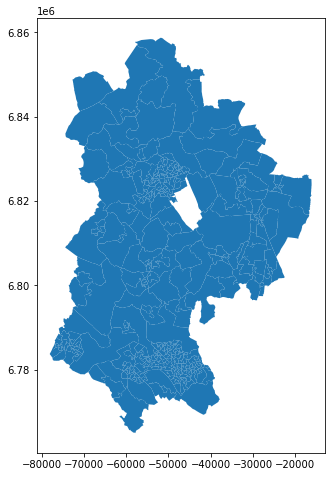

In [18]:
gdf_beds_lsoa_qgis.plot(figsize=(8,8));

Need to do a few tidying up steps.

As the county boundary didn't fall exactly on the LSOA boundary, some slithers of the polygons outside the edges were included.
Here's an example of an LSOA that's in, but only a slither (identified when selecting the full LSOA from the names in this shapefile and when plotting can see it's entirity, which is outside of the Bedfordshire county).

<AxesSubplot:>

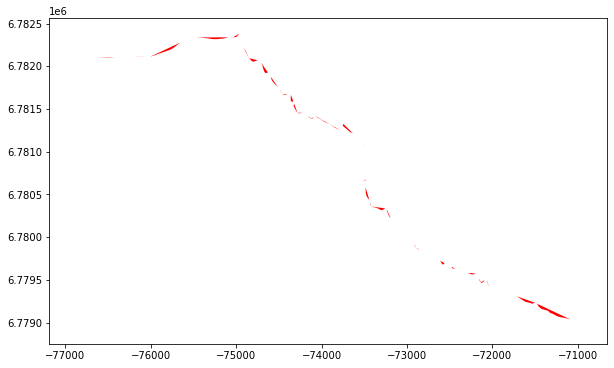

In [19]:
mask = gdf_beds_lsoa_qgis["LSOA11CD"] == "E01017652"
LSOA11CD_E01017652 = gdf_beds_lsoa_qgis[mask]
fig, ax = plt.subplots(figsize=(10, 10))
LSOA11CD_E01017652.plot(ax=ax, facecolor='red')

<AxesSubplot:>

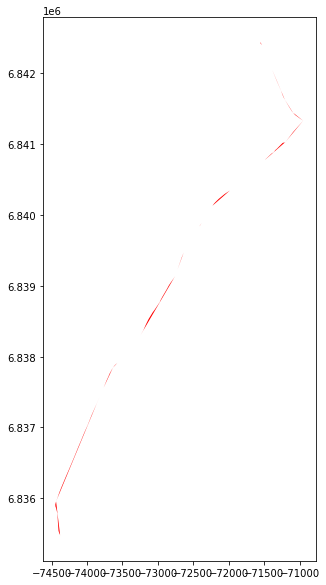

In [20]:
mask = gdf_beds_lsoa_qgis["LSOA11CD"] == "E01027348"
LSOA11CD_E01017652 = gdf_beds_lsoa_qgis[mask]
fig, ax = plt.subplots(figsize=(10, 10))
LSOA11CD_E01017652.plot(ax=ax, facecolor='red')

Need to do a couple of manual tweaks to the resulting LSOAs selected.

In [21]:
# get list of LSOAs in the shapefile
bedfordshire_lsoas = list(gdf_beds_lsoa_qgis["LSOA11CD"])

# 1) add in missing LSOAs
#    The polygon missing could be the cause for clip using GeoPandas not to work
#    but QGIS did as best as it could, and then ingnored the polygon that cause the error
#    Now we can add the single missing polygon
bedfordshire_lsoas.append("E01017486")

# 2) Some LSOAs were assigned to Bedfordshire which are in Buckinghamshire
#    The boundaries of the UA shapefile and LSOA shapefile do not align perfectly
#    so these LSOAs were allocated to Bedford, when they are in Buckinghamshire
#    Identified manually in QGIS (see image).
#    These need to be removed from the list
#  (["E01016800", "E01016797", "E01016803", "E01016735", "E01016734", "E01017670", 
#    "E01017652", "E01017658", "E01017657", "E01016736"])

# 3) Some LSOAs were assigned to Bedfordshire which are in Northamptonshire
#    The boundaries of the UA shapefile and LSOA shapefile do not align perfectly
#    so these LSOAs were allocated to Bedford, when they are in Northamptonshire
#    Identified manually in QGIS (see image).
#    These need to be removed from the list
# (["E01027348", "E01027354", "E01027355","E01027335", "E01027336", "E01027337",
#   "E01027071", "E01027067", "E01027066", "E01027035"])

# Don't think including these will make a difference
# (["E01027031", "E01027044"])

# putting all three lists above into one
not_in_bedfordshire_lsoas = (["E01016800", "E01016797", "E01016803", 
                              "E01016735", "E01016734", "E01017670", 
                              "E01017652", "E01017658", "E01017657", 
                              "E01016736", "E01027348", "E01027354",
                              "E01027355", "E01027335", "E01027336", 
                              "E01027337", "E01027071", "E01027067",
                               "E01027066", "E01027035"])

# Remove these from the Bedfordshire LSOA list
l3 = [x for x in bedfordshire_lsoas if x not in not_in_bedfordshire_lsoas]
bedfordshire_lsoas = l3

For the NHS Bedfordshire, Luton and Milton Keynes CCG, those LSOAs in the Bedfordhsire shape file get allocated to EEAST, and the rest to SCAS.

In [22]:
mask = lsoa_ambo_data["CCG name"].str.contains('Bedfordshire')
lsoa_ambo_data["Ambulance Service Name"][mask] = "South Central"

/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
lsoa_ambo_data.loc["E01017652"]

CCG name                                                    NHS Buckinghamshire CCG
FID                                                                           14121
LSOA11NM                                                        Aylesbury Vale 009B
CCG21CD                                                                   E38000223
CCG21CDH                                                                        14Y
LAD21CD                                                                   E06000060
LAD21NM                                                             Buckinghamshire
NHS CCG code                                                                    14Y
Office for National Statistics (ONS) April 2021 CCG code                  E38000223
Ambulance Service                                                              SCAS
NHS Ambulance Service Region Name                                        South East
NHS Ambulance Service  Region code                                          

In [24]:
lsoa_ambo_data.reset_index(inplace=True)
lsoa_ambo_data.rename({"index":"LSOA11CD"})
lsoa_ambo_data.head()

LSOA11CD          CCG name  FID       LSOA11NM    CCG21CD CCG21CDH  \
0  E01007420  NHS Barnsley CCG    1  Barnsley 016C  E38000006      02P   
1  E01007317  NHS Barnsley CCG    2  Barnsley 018A  E38000006      02P   
2  E01007421  NHS Barnsley CCG    4  Barnsley 027A  E38000006      02P   
3  E01007318  NHS Barnsley CCG    6  Barnsley 018B  E38000006      02P   
4  E01007319  NHS Barnsley CCG    9  Barnsley 015A  E38000006      02P   

     LAD21CD   LAD21NM NHS CCG code  \
0  E08000016  Barnsley          02P   
1  E08000016  Barnsley          02P   
2  E08000016  Barnsley          02P   
3  E08000016  Barnsley          02P   
4  E08000016  Barnsley          02P   

  Office for National Statistics (ONS) April 2021 CCG code Ambulance Service  \
0                                          E38000006                     YAS   
1                                          E38000006                     YAS   
2                                          E38000006                     YAS   
3                                          E38000006                     YAS   
4                                          E38000006                     YAS   

  NHS Ambulance Service Region Name NHS Ambulance Service  Region code  \
0          North East and Yorkshire                                Y63   
1          North East and Yorkshire                                Y63   
2          North East and Yorkshire                                Y63   
3          North East and Yorkshire                                Y63   
4          North East and Yorkshire                                Y63   

  ONS Ambulance Service  Region Code Ambulance Service Name  
0                          E40000009              Yorkshire  
1                          E40000009              Yorkshire  
2                          E40000009              Yorkshire  
3                          E40000009              Yorkshire  
4                          E40000009              Yorkshire

In [25]:
mask = lsoa_ambo_data["LSOA11CD"].isin(bedfordshire_lsoas)
lsoa_ambo_data["Ambulance Service Name"][mask] = "East of England"

/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
len(bedfordshire_lsoas)

412

In [27]:
mask = lsoa_ambo_data["LSOA11CD"] == "E01017652"
lsoa_ambo_data[mask]

LSOA11CD                 CCG name    FID             LSOA11NM  \
4741  E01017652  NHS Buckinghamshire CCG  14121  Aylesbury Vale 009B   

        CCG21CD CCG21CDH    LAD21CD          LAD21NM NHS CCG code  \
4741  E38000223      14Y  E06000060  Buckinghamshire          14Y   

     Office for National Statistics (ONS) April 2021 CCG code  \
4741                                          E38000223         

     Ambulance Service NHS Ambulance Service Region Name  \
4741              SCAS                        South East   

     NHS Ambulance Service  Region code ONS Ambulance Service  Region Code  \
4741                                Y59                          E40000005   

     Ambulance Service Name  
4741          South Central

In [86]:
lsoa_ambo_data.head()

CCG name  FID       LSOA11NM    CCG21CD CCG21CDH  \
LSOA11CD                                                              
E01007420  NHS Barnsley CCG    1  Barnsley 016C  E38000006      02P   
E01007317  NHS Barnsley CCG    2  Barnsley 018A  E38000006      02P   
E01007421  NHS Barnsley CCG    4  Barnsley 027A  E38000006      02P   
E01007318  NHS Barnsley CCG    6  Barnsley 018B  E38000006      02P   
E01007319  NHS Barnsley CCG    9  Barnsley 015A  E38000006      02P   

             LAD21CD   LAD21NM NHS CCG code  \
LSOA11CD                                      
E01007420  E08000016  Barnsley          02P   
E01007317  E08000016  Barnsley          02P   
E01007421  E08000016  Barnsley          02P   
E01007318  E08000016  Barnsley          02P   
E01007319  E08000016  Barnsley          02P   

          Office for National Statistics (ONS) April 2021 CCG code  \
LSOA11CD                                                             
E01007420                                          E38000006         
E01007317                                          E38000006         
E01007421                                          E38000006         
E01007318                                          E38000006         
E01007319                                          E38000006         

          Ambulance Service NHS Ambulance Service Region Name  \
LSOA11CD                                                        
E01007420               YAS          North East and Yorkshire   
E01007317               YAS          North East and Yorkshire   
E01007421               YAS          North East and Yorkshire   
E01007318               YAS          North East and Yorkshire   
E01007319               YAS          North East and Yorkshire   

          NHS Ambulance Service  Region code  \
LSOA11CD                                       
E01007420                                Y63   
E01007317                                Y63   
E01007421                                Y63   
E01007318                                Y63   
E01007319                                Y63   

          ONS Ambulance Service  Region Code Ambulance Service Name  
LSOA11CD                                                             
E01007420                          E40000009              Yorkshire  
E01007317                          E40000009              Yorkshire  
E01007421                          E40000009              Yorkshire  
E01007318                          E40000009              Yorkshire  
E01007319                          E40000009              Yorkshire

Save combined file

In [87]:
lsoa_ambo_data.to_csv('./data/demographic/ambulance_service_regions_lsoa.csv')

Add ambulance data to the LSOA polygons

In [30]:
filename = 'zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip'
gdf_lsoa = gpd.read_file(filename, crs='EPSG:27700')
gdf_lsoa.head()

LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...

In [31]:
lsoa_ambo_data.head()

LSOA11CD          CCG name  FID       LSOA11NM    CCG21CD CCG21CDH  \
0  E01007420  NHS Barnsley CCG    1  Barnsley 016C  E38000006      02P   
1  E01007317  NHS Barnsley CCG    2  Barnsley 018A  E38000006      02P   
2  E01007421  NHS Barnsley CCG    4  Barnsley 027A  E38000006      02P   
3  E01007318  NHS Barnsley CCG    6  Barnsley 018B  E38000006      02P   
4  E01007319  NHS Barnsley CCG    9  Barnsley 015A  E38000006      02P   

     LAD21CD   LAD21NM NHS CCG code  \
0  E08000016  Barnsley          02P   
1  E08000016  Barnsley          02P   
2  E08000016  Barnsley          02P   
3  E08000016  Barnsley          02P   
4  E08000016  Barnsley          02P   

  Office for National Statistics (ONS) April 2021 CCG code Ambulance Service  \
0                                          E38000006                     YAS   
1                                          E38000006                     YAS   
2                                          E38000006                     YAS   
3                                          E38000006                     YAS   
4                                          E38000006                     YAS   

  NHS Ambulance Service Region Name NHS Ambulance Service  Region code  \
0          North East and Yorkshire                                Y63   
1          North East and Yorkshire                                Y63   
2          North East and Yorkshire                                Y63   
3          North East and Yorkshire                                Y63   
4          North East and Yorkshire                                Y63   

  ONS Ambulance Service  Region Code Ambulance Service Name  
0                          E40000009              Yorkshire  
1                          E40000009              Yorkshire  
2                          E40000009              Yorkshire  
3                          E40000009              Yorkshire  
4                          E40000009              Yorkshire

In [32]:
#gdf_lsoa = pd.concat([gdf_lsoa, lsoa_ambo_data[col], axis=1)

In [33]:
gdf_lsoa.set_index('LSOA11CD', inplace=True)
lsoa_ambo_data.set_index('LSOA11CD', inplace=True)
col = 'Ambulance Service Name'#'NHS Ambulance Service Region Name'

# Join the Ambulance data to the LSOA shapefile, but keep all rows in the LSOA shapefile.
# May need to use "how = 'left'". Check and choose.
gdf_lsoa = gdf_lsoa.join(lsoa_ambo_data[col], how = 'outer').reset_index()
gdf_lsoa.head()

LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

                                            geometry Ambulance Service Name  
0  POLYGON ((532105.092 182011.230, 532162.491 18...                 London  
1  POLYGON ((532746.813 181786.891, 532671.688 18...                 London  
2  POLYGON ((532135.145 182198.119, 532158.250 18...                 London  
3  POLYGON ((533807.946 180767.770, 533649.063 18...                 London  
4  POLYGON ((545122.049 184314.931, 545271.917 18...                 London

Now data for Wales in the CCG and Ambulance datafiles. Should still have the Wales LSOA polygons in the shapefile, so populate the "Ambulance Service Name" field with "Wales" for those polygons with LSOA11CD starting with "W"

In [34]:
gdf_lsoa.rename({"index":"LSOA11CD"}, axis=1, inplace=True)
gdf_lsoa.head()

LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

                                            geometry Ambulance Service Name  
0  POLYGON ((532105.092 182011.230, 532162.491 18...                 London  
1  POLYGON ((532746.813 181786.891, 532671.688 18...                 London  
2  POLYGON ((532135.145 182198.119, 532158.250 18...                 London  
3  POLYGON ((533807.946 180767.770, 533649.063 18...                 London  
4  POLYGON ((545122.049 184314.931, 545271.917 18...                 London

gdf_lsoa.reset_index(inplace=True)
gdf_lsoa.rename({"Index":"LSOA11CD"})
gdf_lsoa.head()

In [35]:
mask = gdf_lsoa["LSOA11CD"].str[0] =="W"
gdf_lsoa["Ambulance Service Name"][mask] = "Welsh"
gdf_lsoa.head()

/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

                                            geometry Ambulance Service Name  
0  POLYGON ((532105.092 182011.230, 532162.491 18...                 London  
1  POLYGON ((532746.813 181786.891, 532671.688 18...                 London  
2  POLYGON ((532135.145 182198.119, 532158.250 18...                 London  
3  POLYGON ((533807.946 180767.770, 533649.063 18...                 London  
4  POLYGON ((545122.049 184314.931, 545271.917 18...                 London

Save lsoa shapefile, with the ambulace service data

In [36]:
filename = "data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2_ambulance_service.shp"
gdf_lsoa.to_file(filename)

### Read in hospital data 
(Stroke Team, SSNAP name, Easting, Northing)

In [37]:
gdf_units = gpd.read_file('./data/stroke_hospitals_2022.csv')

gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)
gdf_units = gdf_units.set_crs(epsg=27700)

# Restrict to the units delivering thrombolysis
mask = gdf_units['Use_IVT']=="1"
gdf_units = gdf_units[mask]
gdf_units.head()

Postcode Hospital_name Use_IVT Use_MT  Country Strategic Clinical Network  \
0   RM70AG        RM70AG       1      1  England                 London SCN   
1    E11BB         E11BB       1      1  England                 London SCN   
2   SW66SX        SW66SX       1      1  England                 London SCN   
3   SE59RW        SE59RW       1      1  England                 London SCN   
4   BR68ND        BR68ND       1      0  England                 London SCN   

                                Health Board / Trust  \
0  Barking; Havering and Redbridge University Hos...   
1                             Barts Health NHS Trust   
2              Imperial College Healthcare NHS Trust   
3       King's College Hospital NHS Foundation Trust   
4       King's College Hospital NHS Foundation Trust   

                                     Stroke Team  \
0                      Queen's Hospital, Romford   
1                      The Royal London Hospital   
2                 Charing Cross Hospital, London   
3                King's College Hospital, London   
4  Princess Royal University Hospital; Orpington   

                                SSNAP name Admissions 21/22 Thrombolysis  \
0             Queens Hospital Romford HASU              981          117   
1               Royal London Hospital HASU              861          115   
2              Charing Cross Hospital HASU             1147          113   
3             King's College Hospital HASU              824          124   
4  Princess Royal University Hospital HASU              847          113   

  ivt_rate Easting Northing Neuroscience 30 England Thrombectomy Example  \
0     11.9  551118   187780            1                               0   
1     13.4  534829   181798            1                               1   
2      9.9  524226   176487            1                               1   
3       15  532536   176228            1                               0   
4     13.3  543443   165032            0                               0   

    hospital_city Notes                       geometry  
0         Romford        POINT (551118.000 187780.000)  
1    Royal London        POINT (534829.000 181798.000)  
2   Charing Cross        POINT (524226.000 176487.000)  
3   Kings College        POINT (532536.000 176228.000)  
4  Princess Royal        POINT (543443.000 165032.000)

Convert CRS so compatible with basemap

In [38]:
# When using base maps convert data to epsg:3857
gdf_lsoa = gdf_lsoa.to_crs(epsg=3857)
gdf_units = gdf_units.to_crs(epsg=3857)

Define mapping regions for full plot (and later for the London inset plot)

In [39]:
eng_wales_bounds = gdf_lsoa.bounds
eng_wales_bounds = eng_wales_bounds.merge(gdf_lsoa[col],how = 'left',
                      left_on = eng_wales_bounds.index,
                      right_on = gdf_lsoa.index)
eng_wales_bounds = eng_wales_bounds.set_index(col)
eng_wales_bounds.drop('key_0', axis = 1, inplace = True)
eng_wales_bounds.head()

minx          miny          maxx          maxy
Ambulance Service Name                                                        
London                 -11103.985964  6.712873e+06 -10507.773204  6.714078e+06
London                 -10679.268839  6.712740e+06  -9810.492256  6.714052e+06
London                 -10878.125204  6.713845e+06 -10326.347870  6.714378e+06
London                  -8909.573315  6.711960e+06  -8096.026680  6.713347e+06
London                   9453.003088  6.716908e+06  10419.519918  6.717693e+06

In [40]:
def add_nonoverlapping_text_labels(gdf_units, ax, col, y_step=0.05, fontsize=7):
    """
    #https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position


    """

    text_rectangles = []

    # Better results if the labels are sorted descending in the y axis
    gdf_units['sort_by'] = gdf_units.geometry.y
    gdf_units.sort_values("sort_by", ascending=False, inplace=True)
    del gdf_units["sort_by"]

    # Add labels
    for x, y, label in zip(
        gdf_units.geometry.x, gdf_units.geometry.y, gdf_units[col]):
            text = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points", fontsize=fontsize, 
                        bbox=dict(facecolor='w', alpha=0.3, edgecolor='none', boxstyle="round", pad=0.1))
            x, y = text.get_position()
            new_x = x - 2
            text.set_position((new_x, y))
                    
            rect = text.get_window_extent()

            for other_rect in text_rectangles:
                while Bbox.intersection(rect, other_rect):  # overlapping
                    x, y = text.get_position()
                    new_y = y - y_step
                    text.set_position((x, new_y))
                    rect = text.get_window_extent()
            text_rectangles.append(rect)
    return (ax)

Map Ambulance Region, by LSOA

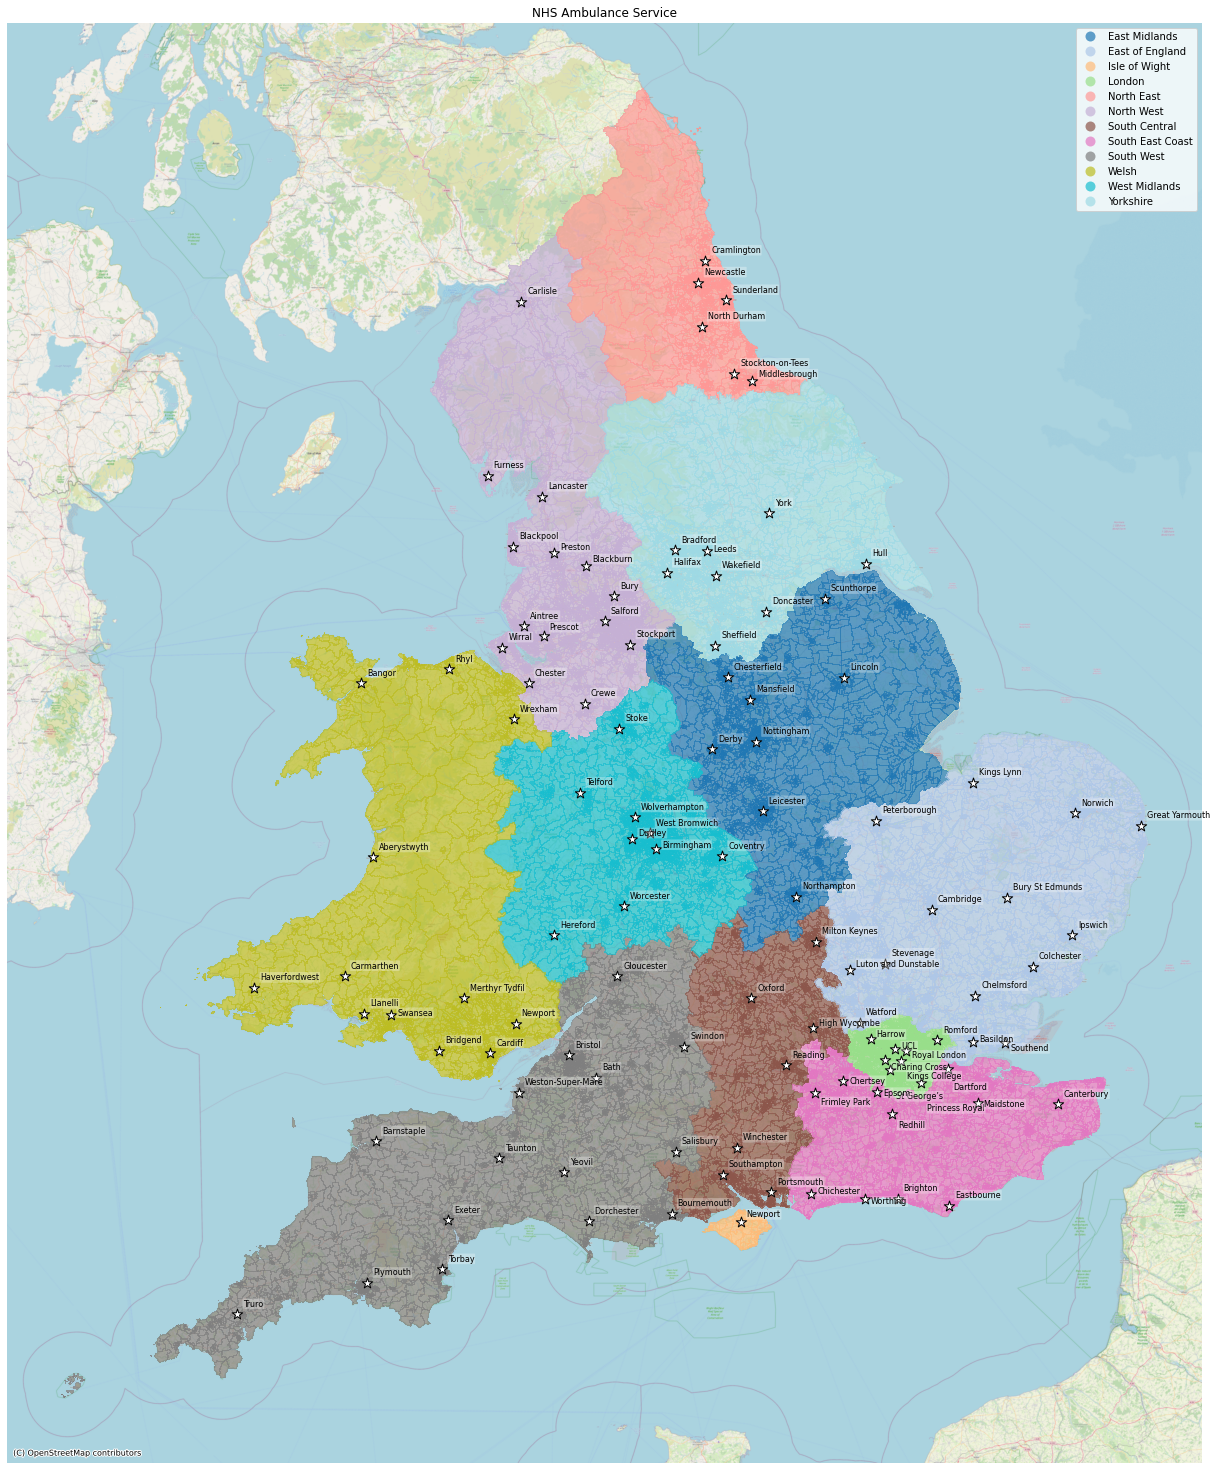

In [41]:
show_labels = True

#col = 'NHS Ambulance Service Region Name'
col_readable = 'NHS Ambulance Service'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='tab20', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')


if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)



# Remove x and y ticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}_v1.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()

In [42]:
gdf_ambulance_service = gdf_lsoa.dissolve(by=col)

In [43]:
gdf_ambulance_service.head()

geometry  \
Ambulance Service Name                                                      
East Midlands           MULTIPOLYGON (((-126267.703 6805374.774, -1260...   
East of England         MULTIPOLYGON (((86442.457 6714283.613, 86442.4...   
Isle of Wight           MULTIPOLYGON (((-134100.233 6549718.622, -1341...   
London                  MULTIPOLYGON (((-10828.350 6674585.657, -10664...   
North East              MULTIPOLYGON (((-191677.889 7273528.352, -1919...   

                         LSOA11CD                      LSOA11NM  \
Ambulance Service Name                                            
East Midlands           E01013128  North East Lincolnshire 010A   
East of England         E01015589             Peterborough 004A   
Isle of Wight           E01017282            Isle of Wight 006A   
London                  E01000001           City of London 001A   
North East              E01008162                Gateshead 027A   

                                           LSOA11NMW  
Ambulance Service Name                                
East Midlands           North East Lincolnshire 010A  
East of England                    Peterborough 004A  
Isle of Wight                     Isle of Wight 006A  
London                           City of London 001A  
North East                            Gateshead 027A

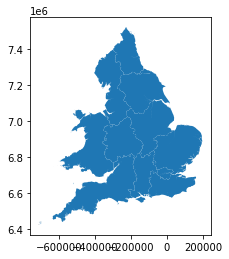

In [44]:
gdf_ambulance_service.plot();

In [45]:
filename = "data/ambulance_service.shp"
gdf_ambulance_service.to_file(filename)

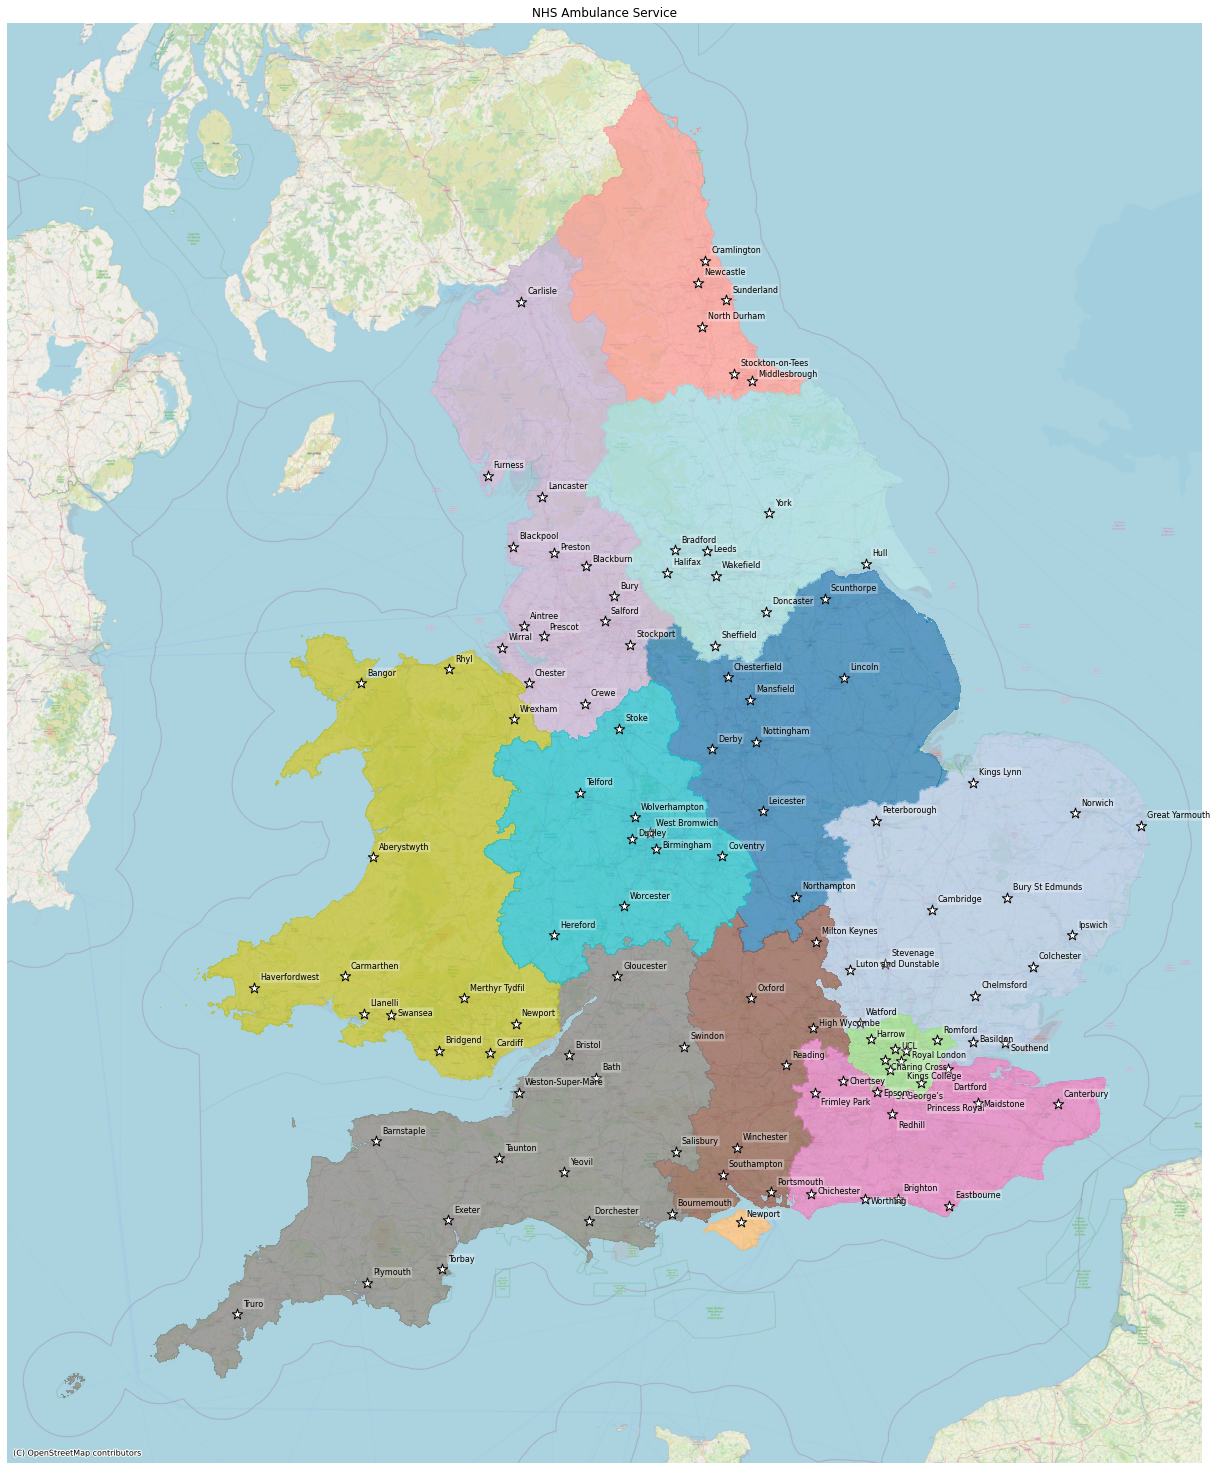

In [46]:
show_labels = True

#col = 'NHS Ambulance Service Region Name'
col_readable = 'NHS Ambulance Service'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ambulance_service.plot(ax=ax, # Set which axes to use for plot (only one here)
#                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='tab20', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')


if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)



# Remove x and y ticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}_1_v1.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()

Hospital in each Ambulance Service.

Use Points-in-polygon: 
https://support.esri.com/en-us/gis-dictionary/point-in-polygon-overlay

Function below from: https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff

In [71]:
def get_pip (gdf, regions):
    r_list = list(regions.index)#Name)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.index==r])#.Name==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region name as the value
        pip_data['Ambulance Service']= r
        #append region data to empty dataframe
        df = df.append(pip_data)
    #checking there are no more than one region assigned to an event    
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    if df.loc[df.Hospital_name.duplicated() == True].shape[0] > 0:
        print("There are id's with more than one region")
    #checking all events have a region
    elif gdf.loc[~gdf.Hospital_name.isin(df.Hospital_name)].shape[0] > 0:
        print("There are id's without an assigned region")
    else:
        print("No discrepancies in results!")
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df

In [72]:
hosp_in_ambo_service = get_pip(gdf_units, gdf_ambulance_service)

Original dataframe count= 113 
New dataframe count= 113
No discrepancies in results!


In [73]:
hosp_in_ambo_service.head()

Postcode Hospital_name Use_IVT Use_MT  Country  \
0  DN157BH       DN157BH       1      0  England   
1   S445BL        S445BL       1      0  England   
2   LN25QY        LN25QY       1      0  England   
3  NG174JL       NG174JL       1      0  England   
4   NG72UH        NG72UH       1      1  England   

     Strategic Clinical Network  \
0  Yorkshire and The Humber SCN   
1  Yorkshire and The Humber SCN   
2             East Midlands SCN   
3             East Midlands SCN   
4             East Midlands SCN   

                                Health Board / Trust  \
0  Northern Lincolnshire and Goole Hospitals NHS ...   
1   Chesterfield Royal Hospital NHS Foundation Trust   
2            United Lincolnshire Hospitals NHS Trust   
3     Sherwood Forest Hospitals NHS Foundation Trust   
4          Nottingham University Hospitals NHS Trust   

                           Stroke Team                           SSNAP name  \
0          Scunthorpe General Hospital          Scunthorpe General Hospital   
1          Chesterfield Royal Hospital                   Chesterfield Royal   
2              Lincoln County Hospital              Lincoln County Hospital   
3       Kings Mill Hospital, Mansfield                  Kings Mill Hospital   
4  Queen's Medical Centre - Nottingham  Queen's Medical Centre - Nottingham   

  Admissions 21/22 Thrombolysis ivt_rate Easting Northing Neuroscience  \
0              641           46      7.2  488297   410936            0   
1              649           53      8.2  440141   371188            0   
2              914           58      6.3  498908   371749            0   
3              668           59      8.8  451460   359962            0   
4             1147          136     11.9  454811   338760            1   

  30 England Thrombectomy Example hospital_city Notes Ambulance Service  
0                               0    Scunthorpe           East Midlands  
1                               0  Chesterfield           East Midlands  
2                               0       Lincoln           East Midlands  
3                               0     Mansfield           East Midlands  
4                               1    Nottingham           East Midlands

In [75]:
#gdf_units = gdf_units.join(hosp_in_ambo_service)
hosp_in_ambo_service = gpd.GeoDataFrame(hosp_in_ambo_service, )
hosp_in_ambo_service["geometry"] = gpd.points_from_xy(
        hosp_in_ambo_service.Easting, hosp_in_ambo_service.Northing)
hosp_in_ambo_service = hosp_in_ambo_service.set_crs(epsg=27700)

In [78]:
# When using base maps convert data to epsg:3857
hosp_in_ambo_service = hosp_in_ambo_service.to_crs(epsg=3857)

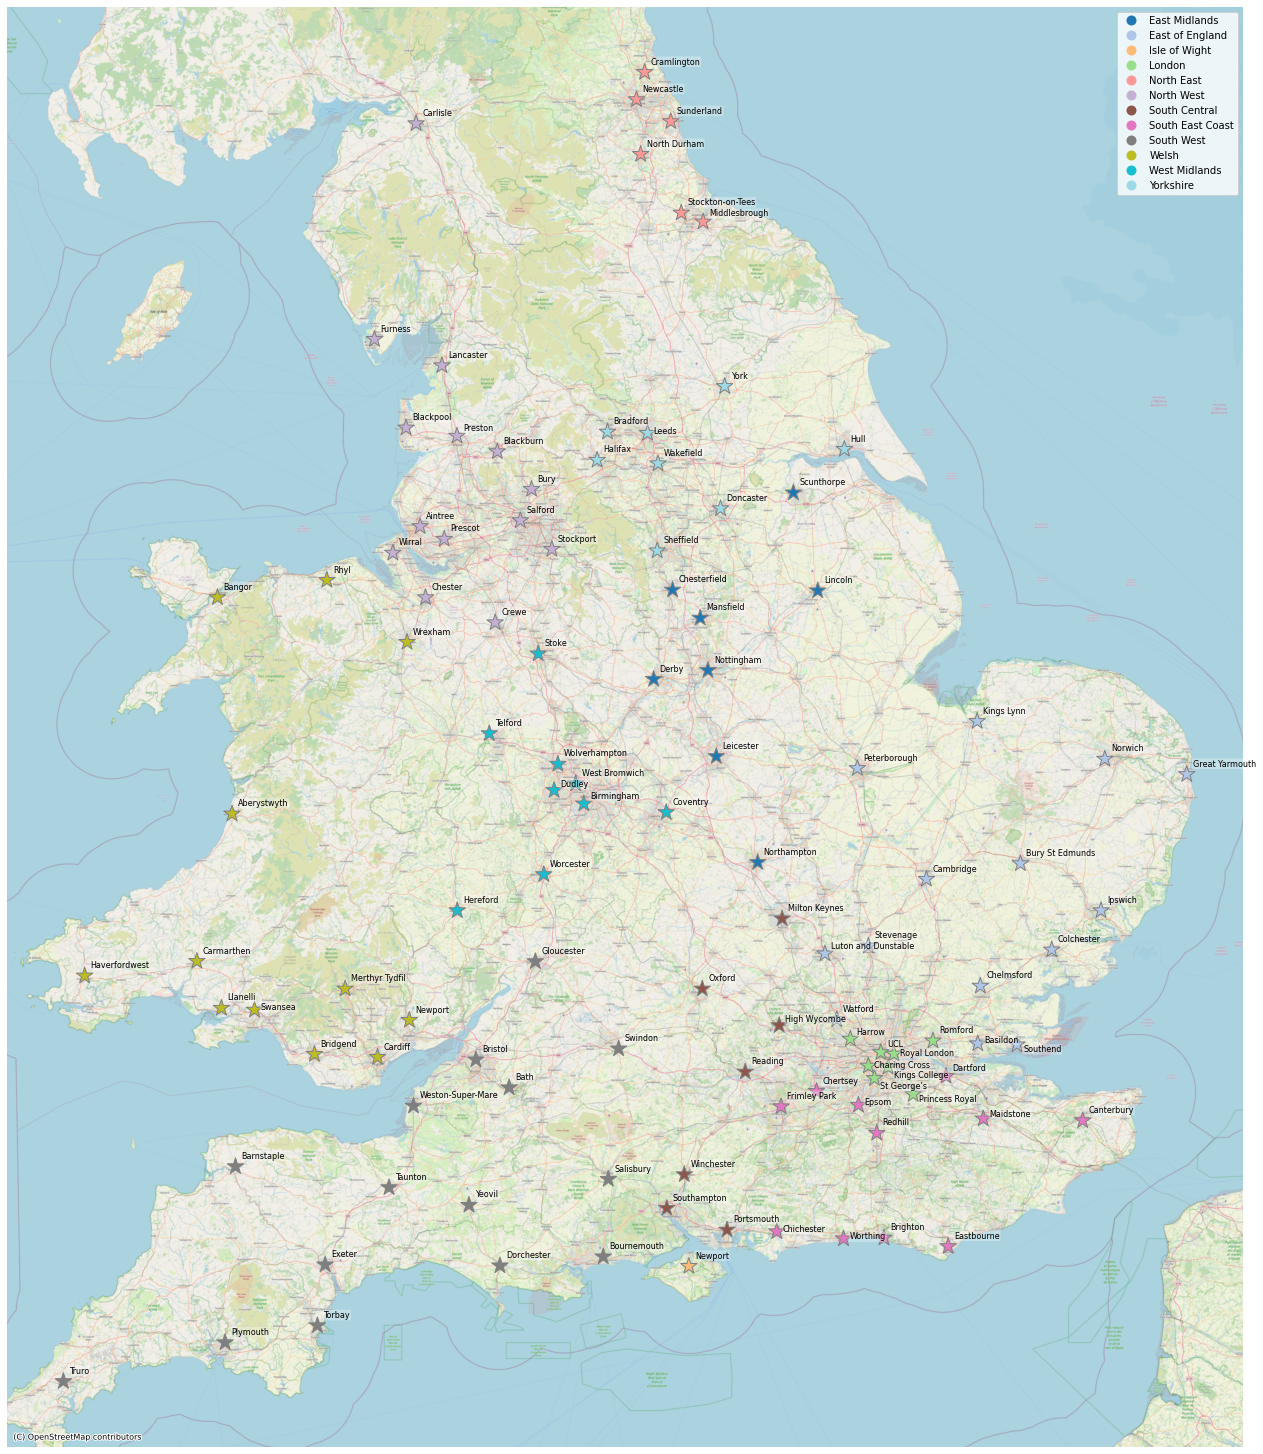

In [85]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
# Plot location of hospitals
hosp_in_ambo_service.plot(ax=ax, column="Ambulance Service", edgecolor='grey', 
                          facecolor='w', markersize=300,cmap='tab20', marker='*',
                          legend=True)

ax = add_nonoverlapping_text_labels(hosp_in_ambo_service, ax, 'hospital_city',
                                    y_step=0.05, fontsize=8)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
#ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_hosp_in_ambo_service.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()